
<a id='jv'></a>
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Job Search V: On-the-Job Search


<a id='index-1'></a>

## Contents

- [Job Search V: On-the-Job Search](#Job-Search-V:-On-the-Job-Search)  
  - [Overview](#Overview)  
  - [Model](#Model)  
  - [Implementation](#Implementation)  
  - [Solving for Policies](#Solving-for-Policies)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

In addition to what’s in Anaconda, this lecture will need the following libraries

In [1]:
!pip install quantecon
!pip install interpolation

## Overview

In this section we solve a simple on-the-job search model

- based on [[LS18]](https://lectures.quantecon.org/py/zreferences.html#ljungqvist2012), exercise 6.18, and [[Jov79]](https://lectures.quantecon.org/py/zreferences.html#jovanovic1979)  


Let’s start with some imports

In [2]:
import numpy as np
import scipy.stats as stats
from interpolation import interp
from numba import njit, prange
import matplotlib.pyplot as plt
%matplotlib inline
from math import gamma

### Model features


<a id='index-2'></a>
- job-specific human capital accumulation combined with on-the-job search  
- infinite horizon dynamic programming with one state variable and two controls  

## Model


<a id='index-3'></a>
Let

- $ x_t $ denote the time-$ t $ job-specific human capital of a worker employed at a given firm  
- $ w_t $ denote current wages  


Let $ w_t = x_t(1 - s_t - \phi_t) $, where

- $ \phi_t $ is investment in job-specific human capital for the current role  
- $ s_t $ is search effort, devoted to obtaining new offers from other firms  


For as long as the worker remains in the current job, evolution of
$ \{x_t\} $ is given by $ x_{t+1} = g(x_t, \phi_t) $

When search effort at $ t $ is $ s_t $, the worker receives a new job
offer with probability $ \pi(s_t) \in [0, 1] $

Value of offer is $ u_{t+1} $, where $ \{u_t\} $ is iid with common distribution $ f $

Worker has the right to reject the current offer and continue with existing job

In particular, $ x_{t+1} = u_{t+1} $ if accepts and $ x_{t+1} = g(x_t, \phi_t) $ if rejects

Letting $ b_{t+1} \in \{0,1\} $ be binary with $ b_{t+1} = 1 $ indicating an offer, we can write


<a id='equation-jd'></a>
$$
x_{t+1}
= (1 - b_{t+1}) g(x_t, \phi_t) + b_{t+1}
    \max \{ g(x_t, \phi_t), u_{t+1}\} \tag{1}
$$

Agent’s objective: maximize expected discounted sum of wages via controls $ \{s_t\} $ and $ \{\phi_t\} $

Taking the expectation of $ v(x_{t+1}) $ and using [(1)](#equation-jd),
the Bellman equation for this problem can be written as


<a id='equation-jvbell'></a>
$$
v(x)
= \max_{s + \phi \leq 1}
    \left\{
        x (1 - s - \phi) + \beta (1 - \pi(s)) v[g(x, \phi)] +
        \beta \pi(s) \int v[g(x, \phi) \vee u] f(du)
     \right\} \tag{2}
$$

Here nonnegativity of $ s $ and $ \phi $ is understood, while
$ a \vee b := \max\{a, b\} $

### Parameterization


<a id='index-4'></a>
In the implementation below, we will focus on the parameterization

$$
g(x, \phi) = A (x \phi)^{\alpha},
\quad
\pi(s) = \sqrt s
\quad \text{and} \quad
f = \text{Beta}(2, 2)
$$

with default parameter values

- $ A = 1.4 $  
- $ \alpha = 0.6 $  
- $ \beta = 0.96 $  


The $ \text{Beta}(2,2) $ distribution is supported on $ (0,1) $ - it has a unimodal, symmetric density peaked at 0.5


<a id='jvboecalc'></a>

### Back-of-the-Envelope Calculations

Before we solve the model, let’s make some quick calculations that
provide intuition on what the solution should look like

To begin, observe that the worker has two instruments to build
capital and hence wages:

1. invest in capital specific to the current job via $ \phi $  
1. search for a new job with better job-specific capital match via $ s $  


Since wages are $ x (1 - s - \phi) $, marginal cost of investment via either $ \phi $ or $ s $ is identical

Our risk neutral worker should focus on whatever instrument has the highest expected return

The relative expected return will depend on $ x $

For example, suppose first that $ x = 0.05 $

- If $ s=1 $ and $ \phi = 0 $, then since $ g(x,\phi) = 0 $,
  taking expectations of [(1)](#equation-jd) gives expected next period capital equal to $ \pi(s) \mathbb{E} u
  = \mathbb{E} u = 0.5 $  
- If $ s=0 $ and $ \phi=1 $, then next period capital is $ g(x, \phi) = g(0.05, 1) \approx 0.23 $  


Both rates of return are good, but the return from search is better

Next suppose that $ x = 0.4 $

- If $ s=1 $ and $ \phi = 0 $, then expected next period capital is again $ 0.5 $  
- If $ s=0 $ and $ \phi = 1 $, then $ g(x, \phi) = g(0.4, 1) \approx 0.8 $  


Return from investment via $ \phi $ dominates expected return from search

Combining these observations gives us two informal predictions:

1. At any given state $ x $, the two controls $ \phi $ and $ s $ will
  function primarily as substitutes — worker will focus on whichever instrument has the higher expected return  
1. For sufficiently small $ x $, search will be preferable to investment in
  job-specific human capital.  For larger $ x $, the reverse will be true  


Now let’s turn to implementation, and see if we can match our predictions

## Implementation


<a id='index-5'></a>
We will set up a class `JVWorker` that holds the parameters of the model described above

In [3]:
class JVWorker:
    r"""
    A Jovanovic-type model of employment with on-the-job search.

    """

    def __init__(self,
                 A=1.4,
                 α=0.6,
                 β=0.96,         # Discount factor
                 π=np.sqrt,      # Search effort function
                 a=2,            # Parameter of f
                 b=2,            # Parameter of f
                 grid_size=50,
                 mc_size=100,
                 ɛ=1e-4):

        self.A, self.α, self.β, self.π = A, α, β, π
        self.mc_size, self.ɛ = mc_size, ɛ

        self.g = njit(lambda x, ϕ: A * (x * ϕ)**α)     # Transition function
        self.f_rvs = np.random.beta(a, b, mc_size)

        # Max of grid is the max of a large quantile value for f and the
        # fixed point y = g(y, 1)
        ɛ = 1e-4
        grid_max = max(A**(1 / (1 - α)), stats.beta(a, b).ppf(1 - ɛ))

        # Human capital
        self.x_grid = np.linspace(ɛ, grid_max, grid_size)

The function `operator_factory` takes an instance of this class and returns a
jitted version of the Bellman operator `T`, ie.

$$
Tv(x)
= \max_{s + \phi \leq 1} w(s, \phi)
$$

where


<a id='equation-defw'></a>
$$
w(s, \phi)
 := x (1 - s - \phi) + \beta (1 - \pi(s)) v[g(x, \phi)] +
         \beta \pi(s) \int v[g(x, \phi) \vee u] f(du) \tag{3}
$$

When we represent $ v $, it will be with a NumPy array `v` giving values on grid `x_grid`

But to evaluate the right-hand side of [(3)](#equation-defw), we need a function, so
we replace the arrays `v` and `x_grid` with a function `v_func` that gives linear
interpolation of `v` on `x_grid`

Inside the `for` loop, for each `x` in the grid over the state space, we
set up the function $ w(z) = w(s, \phi) $ defined in [(3)](#equation-defw)

The function is maximized over all feasible $ (s, \phi) $ pairs

Another function, `get_greedy` returns the optimal policies of `s` and $ \phi $
given a value function

In [4]:
def operator_factory(jv, parallel_flag=True):

    """
    Returns a jitted version of the Bellman operator T

    jv is an instance of JVWorker

    """

    π, β = jv.π, jv.β
    x_grid, ɛ, mc_size = jv.x_grid, jv.ɛ, jv.mc_size
    f_rvs, g = jv.f_rvs, jv.g

    @njit
    def objective(z, x, v):
        s, ϕ = z
        v_func = lambda x: interp(x_grid, v, x)

        integral = 0
        for m in range(mc_size):
            u = f_rvs[m]
            integral += v_func(max(g(x, ϕ), u))
        integral = integral / mc_size

        q = π(s) * integral + (1 - π(s)) * v_func(g(x, ϕ))
        return x * (1 - ϕ - s) + β * q

    @njit(parallel=parallel_flag)
    def T(v):
        """
        The Bellman operator
        """

        v_new = np.empty_like(v)
        for i in prange(len(x_grid)):
            x = x_grid[i]

            # === Search on a grid === #
            search_grid = np.linspace(ɛ, 1, 15)
            max_val = -1
            for s in search_grid:
                for ϕ in search_grid:
                    current_val = objective((s, ϕ), x, v) if s + ϕ <= 1 else -1
                    if current_val > max_val:
                        max_val = current_val
            v_new[i] = max_val

        return v_new

    @njit
    def get_greedy(v):
        """
        Computes the v-greedy policy of a given function v
        """
        s_policy, ϕ_policy = np.empty_like(v), np.empty_like(v)

        for i in range(len(x_grid)):
            x = x_grid[i]
            # === Search on a grid === #
            search_grid = np.linspace(ɛ, 1, 15)
            max_val = -1
            for s in search_grid:
                for ϕ in search_grid:
                    current_val = objective((s, ϕ), x, v) if s + ϕ <= 1 else -1
                    if current_val > max_val:
                        max_val = current_val
                        max_s, max_ϕ = s, ϕ
                        s_policy[i], ϕ_policy[i] = max_s, max_ϕ
        return s_policy, ϕ_policy

    return T, get_greedy

To solve the model, we will write a function that uses the Bellman operator
and iterates to find a fixed point

In [5]:
def solve_model(jv,
                use_parallel=True,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):

    """
    Solves the model by value function iteration

    * jv is an instance of JVWorker

    """

    T, _ = operator_factory(jv, parallel_flag=use_parallel)

    # Set up loop
    v = jv.x_grid * 0.5  # Initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_new

## Solving for Policies


<a id='index-6'></a>
Let’s plot the optimal policies and see what they look like


<a id='jv-policies'></a>

Error at iteration 25 is 0.15110789944202985.


Error at iteration 50 is 0.05445879082483884.


Error at iteration 75 is 0.019626769417332213.


Error at iteration 100 is 0.00707342326053606.


Error at iteration 125 is 0.002549238520050068.


Error at iteration 150 is 0.0009187371931140831.


Error at iteration 175 is 0.0003311098680551794.


Error at iteration 200 is 0.00011933090936722124.

Converged in 205 iterations.


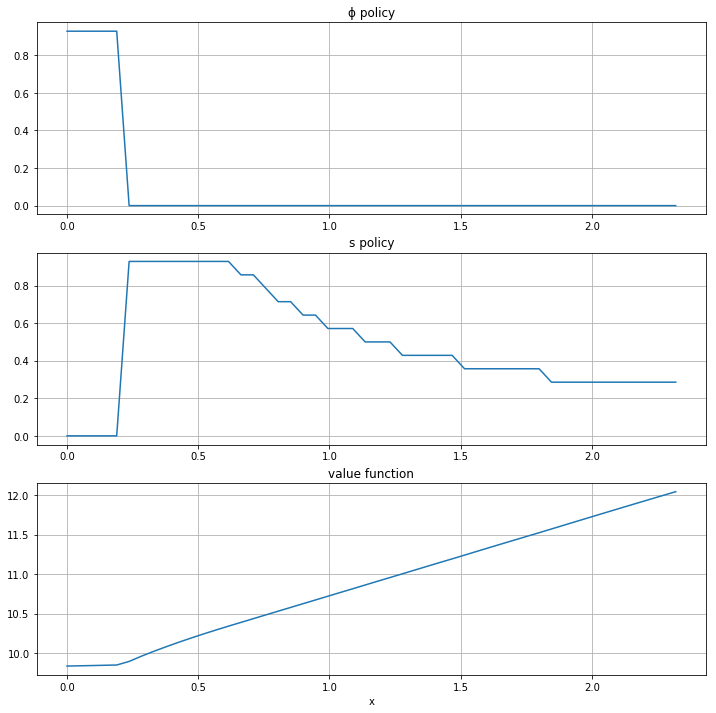

In [6]:
jv = JVWorker()
T, get_greedy = operator_factory(jv)
v_star = solve_model(jv)
s_star, ϕ_star = get_greedy(v_star)
plots = [s_star, ϕ_star, v_star]
titles = ["ϕ policy", "s policy", "value function"]

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

for ax, plot, title in zip(axes, plots, titles):
    ax.plot(jv.x_grid, plot)
    ax.set(title=title)
    ax.grid()

axes[-1].set_xlabel("x")
plt.show()

The horizontal axis is the state $ x $, while the vertical axis gives $ s(x) $ and $ \phi(x) $

Overall, the policies match well with our predictions from [above](#jvboecalc)

- Worker switches from one investment strategy to the other depending on relative return  
- For low values of $ x $, the best option is to search for a new job  
- Once $ x $ is larger, worker does better by investing in human capital specific to the current position  

## Exercises


<a id='jv-ex1'></a>

### Exercise 1

Let’s look at the dynamics for the state process $ \{x_t\} $ associated with these policies

The dynamics are given by [(1)](#equation-jd) when $ \phi_t $ and $ s_t $ are
chosen according to the optimal policies, and $ \mathbb{P}\{b_{t+1} = 1\}
= \pi(s_t) $

Since the dynamics are random, analysis is a bit subtle

One way to do it is to plot, for each $ x $ in a relatively fine grid
called `plot_grid`, a
large number $ K $ of realizations of $ x_{t+1} $ given $ x_t =
x $

Plot this with one dot for each realization, in the form of a 45 degree
diagram, setting

```python3
jv = JVWorker(grid_size=25, mc_size=50)
plot_grid_max, plot_grid_size = 1.2, 100
plot_grid = np.linspace(0, plot_grid_max, plot_grid_size)
fig, ax = plt.subplots()
ax.set_xlim(0, plot_grid_max)
ax.set_ylim(0, plot_grid_max)
```


By examining the plot, argue that under the optimal policies, the state
$ x_t $ will converge to a constant value $ \bar x $ close to unity

Argue that at the steady state, $ s_t \approx 0 $ and $ \phi_t \approx 0.6 $


<a id='jv-ex2'></a>

### Exercise 2

In the preceding exercise we found that $ s_t $ converges to zero
and $ \phi_t $ converges to about 0.6

Since these results were calculated at a value of $ \beta $ close to
one, let’s compare them to the best choice for an *infinitely* patient worker

Intuitively, an infinitely patient worker would like to maximize steady state
wages, which are a function of steady state capital

You can take it as given—it’s certainly true—that the infinitely patient worker does not
search in the long run (i.e., $ s_t = 0 $ for large $ t $)

Thus, given $ \phi $, steady state capital is the positive fixed point
$ x^*(\phi) $ of the map $ x \mapsto g(x, \phi) $

Steady state wages can be written as $ w^*(\phi) = x^*(\phi) (1 - \phi) $

Graph $ w^*(\phi) $ with respect to $ \phi $, and examine the best
choice of $ \phi $

Can you give a rough interpretation for the value that you see?

## Solutions

### Exercise 1

Here’s code to produce the 45 degree diagram

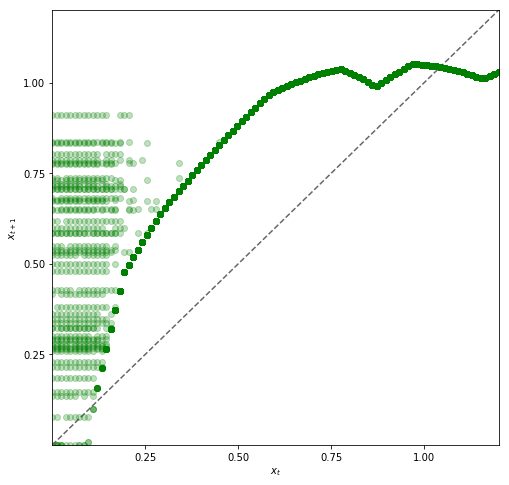

In [7]:
jv = JVWorker(grid_size=25, mc_size=50)
π, g, f_rvs, x_grid = jv.π, jv.g, jv.f_rvs, jv.x_grid
T, get_greedy = operator_factory(jv)
v_star = solve_model(jv, verbose=False)
s_policy, ϕ_policy = get_greedy(v_star)

# Turn the policy function arrays into actual functions
s = lambda y: interp(x_grid, s_policy, y)
ϕ = lambda y: interp(x_grid, ϕ_policy, y)

def h(x, b, u):
    return (1 - b) * g(x, ϕ(x)) + b * max(g(x, ϕ(x)), u)


plot_grid_max, plot_grid_size = 1.2, 100
plot_grid = np.linspace(0, plot_grid_max, plot_grid_size)
fig, ax = plt.subplots(figsize=(8, 8))
ticks = (0.25, 0.5, 0.75, 1.0)
ax.set(xticks=ticks, yticks=ticks,
       xlim=(0, plot_grid_max),
       ylim=(0, plot_grid_max),
       xlabel='$x_t$', ylabel='$x_{t+1}$')

ax.plot(plot_grid, plot_grid, 'k--', alpha=0.6)  # 45 degree line
for x in plot_grid:
    for i in range(jv.mc_size):
        b = 1 if np.random.uniform(0, 1) < π(s(x)) else 0
        u = f_rvs[i]
        y = h(x, b, u)
        ax.plot(x, y, 'go', alpha=0.25)

plt.show()

Looking at the dynamics, we can see that

- If $ x_t $ is below about 0.2 the dynamics are random, but
  $ x_{t+1} > x_t $ is very likely  
- As $ x_t $ increases the dynamics become deterministic, and
  $ x_t $ converges to a steady state value close to 1  


Referring back to the figure [here](#jv-policies) we see that $ x_t \approx 1 $ means that
$ s_t = s(x_t) \approx 0 $ and
$ \phi_t = \phi(x_t) \approx 0.6 $

### Exercise 2

The figure can be produced as follows

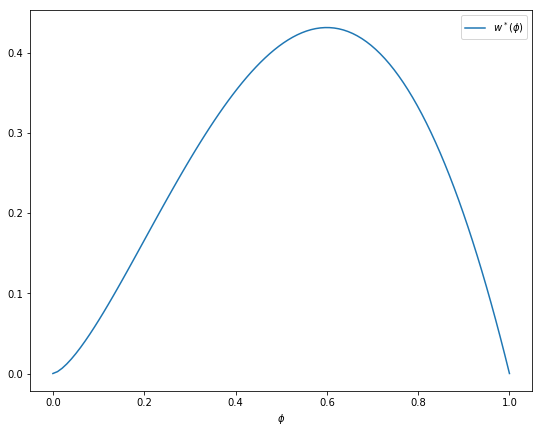

In [8]:
jv = JVWorker()

def xbar(ϕ):
    A, α = jv.A, jv.α
    return (A * ϕ**α)**(1 / (1 - α))

ϕ_grid = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(9, 7))
ax.set(xlabel='$\phi$')
ax.plot(ϕ_grid, [xbar(ϕ) * (1 - ϕ) for ϕ in ϕ_grid], label='$w^*(\phi)$')
ax.legend()

plt.show()

Observe that the maximizer is around 0.6

This this is similar to the long run value for $ \phi $ obtained in
exercise 1

Hence the behaviour of the infinitely patent worker is similar to that
of the worker with $ \beta = 0.96 $

This seems reasonable, and helps us confirm that our dynamic programming
solutions are probably correct